In [36]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
Layer=keras.layers.Layer

class Time2Vector(Layer): #Time embedding layer
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    x = tf.math.reduce_mean(x[:,:,:], axis=-1) # Convert (batch, seq_len, 5) to (batch, seq_len)
    time_linear = self.weights_linear * x + self.bias_linear
    time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 2)

class SingleAttention(Layer): #Attention layer
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.key = Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.value = Dense(self.d_v, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out 

class MultiAttention(Layer): #Multihead attention
  def __init__(self, d_k, d_v, n_heads,filt_dim):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.filt_dim=filt_dim
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    self.linear = Dense(self.filt_dim, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

class TransformerEncoder(Layer): #Combining everything into a Transformer encoder
  def __init__(self, d_k, d_v, n_heads, ff_dim,filt_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.filt_dim=filt_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads,self.filt_dim)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    self.ff_conv1D_2 = Conv1D(filters=self.filt_dim, kernel_size=1) # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

seq_len = 9
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

def create_model(latent_dim):
    filt_dim = latent_dim + 2
    '''Initialize time and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, filt_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, filt_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, filt_dim)


    '''Construct model'''
    in_seq = Input(shape=(seq_len, latent_dim))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(latent_dim, activation='linear')(x)
    out = LeakyReLU()(x)

    model = Model(inputs=in_seq, outputs=out)
    #model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
    model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())
    return model


In [37]:
!pip -q install deeptrack

import deeptrack as dt
IMAGE_SIZE=64
sequence_length=10#Number of frames per sequence
MIN_SIZE=.5e-6
MAX_SIZE=1.5e-6
MAX_VEL=10 #Maximum velocity. The higher the trickier!
MAX_PARTICLES=3 #Max number of particles in each sequence. The higher the trickier!

#Defining properties of the particles
particle=dt.Sphere(intensity=lambda: 10+10*np.random.rand(),
                   radius=lambda: MIN_SIZE+np.random.rand()*(MAX_SIZE-MIN_SIZE),
                   position=lambda: IMAGE_SIZE*np.random.rand(2),vel=lambda: MAX_VEL*np.random.rand(2),
                   position_unit="pixel")

#Defining an update rule for the particle position
def get_position(previous_value,vel):

    newv=previous_value+vel
    for i in range(2):
        if newv[i]>63:
            newv[i]=63-np.abs(newv[i]-63)
            vel[i]=-vel[i]
        elif newv[i]<0:
            newv[i]=np.abs(newv[i])
            vel[i]=-vel[i]
    return newv

particle=dt.Sequential(particle,position=get_position)

#Defining properties of the microscope
optics=dt.Fluorescence(NA=1,output_region= (0, 0,IMAGE_SIZE, IMAGE_SIZE), 
    magnification=10,
    resolution=(1e-6, 1e-6),
    wavelength=633e-9)

#Combining everything into a dataset. 
#Note that the sequences are flipped in different directions, so that each unique sequence defines
#in fact 8 sequences flipped in different directions, to speed up data generation
dataset=dt.FlipUD(dt.FlipDiagonal(dt.FlipLR(dt.Sequence(optics(particle**(lambda: 1+np.random.randint(MAX_PARTICLES))),sequence_length=sequence_length))))

def datasetCreator(train_length,val_length,test_length):
    train_data = []
    for i in range(train_length):
      train_data.extend(dataset.update().resolve())

    val_data = []
    for i in range(val_length):
      val_data.extend(dataset.update().resolve())
    print(len(val_data))
    test_data = []
    for i in range(test_length):
      test_data.extend(dataset.update().resolve())

    train_data = np.asarray(train_data)
    val_data = np.asarray(val_data)
    test_data = np.asarray(test_data)
    return train_data, val_data, test_data




In [38]:
train_data, val_data, test_data = datasetCreator(train_length=1000,val_length=100,test_length=100) 

1000


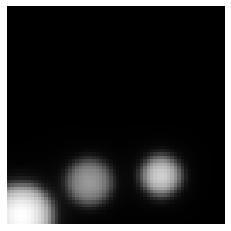

In [39]:
dataset.update().plot(cmap="gray") #This generates a new sequence and plots it
video=dataset.update().resolve() #This generates a new sequence and stores in in "video"

In [40]:


from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras.layers import Dense, GlobalAveragePooling1D, Input,Conv1D, Dropout, LayerNormalization, Concatenate, LeakyReLU

class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(64, 64, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=4),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=4),
      layers.Flatten()
    ])
    
    self.decoder = tf.keras.Sequential([
      layers.Reshape((4,4,8)),
      layers.Conv2DTranspose(8, kernel_size=7, strides=4, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=7, strides=4, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='linear', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder()
autoencoder.compile(optimizer = "adam", loss = losses.MeanSquaredError())



autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 16, 16)        160       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 8)           1160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [41]:
autoencoder.fit(train_data, train_data,
                epochs=30,
                shuffle=True,
                validation_data=(test_data, test_data))

Epoch 1/30
313/313 [==============================] - 2s 6ms/step - loss: 18.0561 - val_loss: 1.4655
Epoch 2/30
313/313 [==============================] - 2s 6ms/step - loss: 1.3834 - val_loss: 0.7371
Epoch 3/30
313/313 [==============================] - 2s 5ms/step - loss: 0.7484 - val_loss: 0.5235
Epoch 4/30
313/313 [==============================] - 2s 6ms/step - loss: 0.5687 - val_loss: 0.4347
Epoch 5/30
313/313 [==============================] - 2s 6ms/step - loss: 0.4875 - val_loss: 0.3942
Epoch 6/30
313/313 [==============================] - 2s 6ms/step - loss: 0.4348 - val_loss: 0.3675
Epoch 7/30
313/313 [==============================] - 2s 6ms/step - loss: 0.4019 - val_loss: 0.3158
Epoch 8/30
313/313 [==============================] - 2s 6ms/step - loss: 0.3513 - val_loss: 0.2849
Epoch 9/30
313/313 [==============================] - 2s 6ms/step - loss: 0.3169 - val_loss: 0.2461
Epoch 10/30
313/313 [==============================] - 2s 6ms/step - loss: 0.2799 - val_loss: 0.213

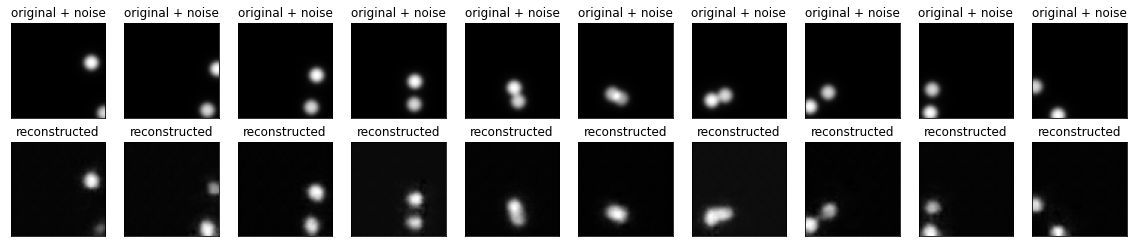

In [42]:
encoded_imgs = autoencoder.encoder(train_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()


n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(train_data[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [43]:
# Gen pictures
train_pictures = []
for i in range(3000):
  train_pictures.extend(dataset.update().resolve())

validation_pictures = []
for i in range(300):
  validation_pictures.extend(dataset.update().resolve())

train_data = np.asarray(train_pictures)
val_data = np.asarray(validation_pictures)

In [44]:
latent_dim = 128

# Normalize
# train_data /= train_data.max()
# val_data /= val_data.max()

#Create transformer
model = create_model(latent_dim)
model.summary()

# compress training data
comp_train = autoencoder.encoder(train_data)
comp_val   = autoencoder.encoder(val_data)

# prep data
comp_train_reshaped = tf.reshape(comp_train,(3000,10,latent_dim))

train_x = comp_train_reshaped[:,0:9,:]
train_y = comp_train_reshaped[:,9,:]
comp_val_reshaped   = tf.reshape(comp_val,   (300,10,latent_dim))
val_x = comp_val_reshaped[:,0:9,:]
val_y = comp_val_reshaped[:,9,:]



Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 9, 128)]     0                                            
__________________________________________________________________________________________________
time2_vector_3 (Time2Vector)    (None, 9, 2)         36          input_6[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 9, 130)       0           input_6[0][0]                    
                                                                 time2_vector_3[0][0]             
__________________________________________________________________________________________________
transformer_encoder_9 (Transfor (None, 9, 130)       1674252     concatenate_3[0][0]        

In [46]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.02, restore_best_weights=True)
model.fit(train_x, train_y,
                epochs=100,
                shuffle=True,
                batch_size=10,
                validation_data=(val_x, val_y),
          callbacks=[es]
          )

model.save("transformer_j2_90")

Epoch 1/100
300/300 [==============================] - 37s 125ms/step - loss: 11.7783 - val_loss: 15.1525
Epoch 2/100
300/300 [==============================] - 37s 125ms/step - loss: 10.8258 - val_loss: 14.6173
Epoch 3/100
300/300 [==============================] - 37s 124ms/step - loss: 10.0897 - val_loss: 14.0382
Epoch 4/100
300/300 [==============================] - 37s 124ms/step - loss: 9.5880 - val_loss: 13.7081
Epoch 5/100
300/300 [==============================] - 37s 123ms/step - loss: 9.1722 - val_loss: 13.5098
Epoch 6/100
300/300 [==============================] - 37s 122ms/step - loss: 8.5567 - val_loss: 13.6074
Epoch 7/100
300/300 [==============================] - 37s 122ms/step - loss: 8.3089 - val_loss: 13.3314
Epoch 8/100
300/300 [==============================] - 37s 123ms/step - loss: 8.0791 - val_loss: 13.0679
Epoch 9/100
300/300 [==============================] - 37s 123ms/step - loss: 7.7762 - val_loss: 13.2648
Epoch 10/100
300/300 [==============================

INFO:tensorflow:Assets written to: transformer_j2_90/assets


INFO:tensorflow:Assets written to: transformer_j2_90/assets


In [47]:
predicted_frames_comp = model.predict(train_x)

predicted_frames   = autoencoder.decoder(predicted_frames_comp).numpy()
print(np.shape(predicted_frames))




(3000, 64, 64, 1)


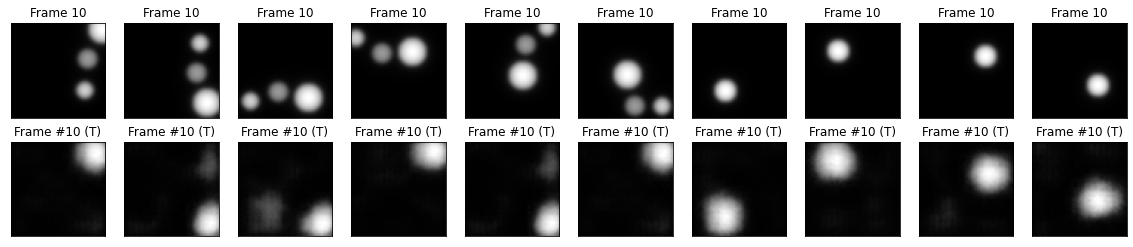

In [48]:

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("Frame 10")
    plt.imshow(tf.squeeze(train_data[ 9 + 9*i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("Frame #10 (T)")
    plt.imshow(tf.squeeze(predicted_frames[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()




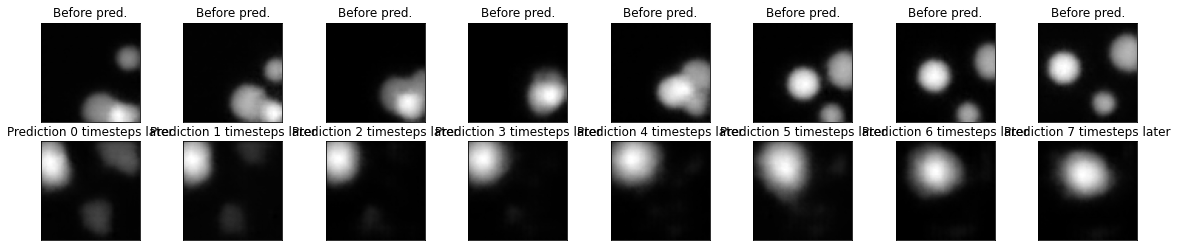

In [68]:
## PREDICT FUTURE WITH TRANSFORMER

## Ta in en video med 9 frames

## Predicta den 10ende

## Appenda den 10ende och poppa första

## Fortsätt typ 10 ggr



goal = np.reshape(val_x[16],(9,128))
# goal = autoencoder.decoder.predict(goal)

transform_test = model.predict(transform_in)
goal = autoencoder.decoder.predict(goal)
transform_test = autoencoder.decoder.predict(transform_test)


transform_in = val_x[16]
transform_in = np.reshape(transform_in,(1,9,latent_dim))

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):

  ax = plt.subplot(2, n, i + 1)
  plt.imshow(goal[i].squeeze(), cmap="gray")
  plt.title("Before pred.")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)

  transform_test = model.predict(transform_in)

  transform_in = np.reshape(transform_in,(9,latent_dim))
  transform_in = np.vstack((transform_in,transform_test))
  transform_in = transform_in[1:10,:]

  transform_in = np.reshape(transform_in,(1,9,latent_dim))


  transform_test = autoencoder.decoder.predict(transform_test)
  plt.imshow(transform_test.squeeze(), cmap="gray")
  plt.title(f"Prediction {i} timesteps later")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# **LSTM**

In [57]:
from tensorflow.keras.layers import LSTM
def create_LSTM_model():
  '''Initialize'''

  '''Construct model'''
  in_seq = Input(shape=(seq_len, latent_dim))
  x = LSTM(8)(in_seq)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(latent_dim, activation='linear')(x)
  # out = LeakyReLU()(out)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(optimizer='adam', loss=losses.MeanSquaredError())
  return model

lstm_model = create_LSTM_model()
lstm_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 9, 128)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 4384      
_________________________________________________________________
dropout_12 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                576       
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
Total params: 13,280
Trainable params: 13,280
Non-trainable params: 0
_______________________________________________________

In [58]:
lstm_model.fit(train_x, train_y,
                epochs=30,
                shuffle=True,
                batch_size=10,
                validation_data=(val_x, val_y)
)


Epoch 1/30
300/300 [==============================] - 2s 4ms/step - loss: 31.6294 - val_loss: 32.6609
Epoch 2/30
300/300 [==============================] - 1s 3ms/step - loss: 25.4647 - val_loss: 29.7317
Epoch 3/30
300/300 [==============================] - 1s 3ms/step - loss: 24.1183 - val_loss: 27.9957
Epoch 4/30
300/300 [==============================] - 1s 3ms/step - loss: 21.7457 - val_loss: 26.2383
Epoch 5/30
300/300 [==============================] - 1s 3ms/step - loss: 20.7192 - val_loss: 25.0239
Epoch 6/30
300/300 [==============================] - 1s 3ms/step - loss: 20.3988 - val_loss: 23.8409
Epoch 7/30
300/300 [==============================] - 1s 3ms/step - loss: 19.6367 - val_loss: 23.0653
Epoch 8/30
300/300 [==============================] - 1s 3ms/step - loss: 19.0701 - val_loss: 21.6927
Epoch 9/30
300/300 [==============================] - 1s 3ms/step - loss: 18.3836 - val_loss: 21.4395
Epoch 10/30
300/300 [==============================] - 1s 3ms/step - loss: 18.6523

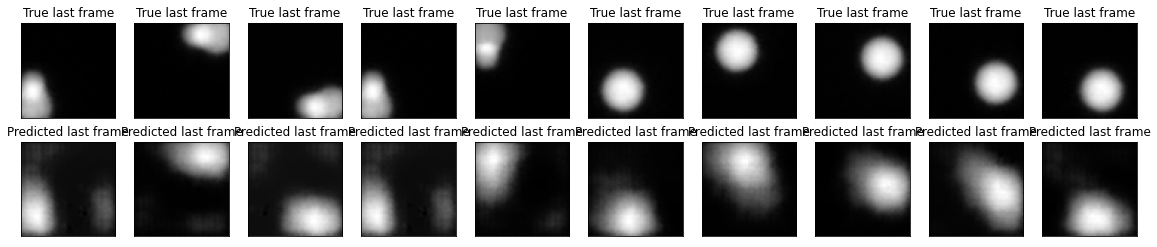

In [64]:
i_pic = 1
transform_in = val_x[i_pic:i_pic+10]
transform_in = np.reshape(transform_in,(10,9,latent_dim))
goal = val_y[i_pic:i_pic+10]
goal = np.reshape(goal, (10,latent_dim))

transform_test = lstm_model.predict(transform_in)
goal = autoencoder.decoder.predict(goal)
transform_test = autoencoder.decoder.predict(transform_test)


n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(goal[i].squeeze(), cmap="gray")
  plt.title("True last frame")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(transform_test[i].squeeze(), cmap="gray")
  plt.title("Predicted last frame")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

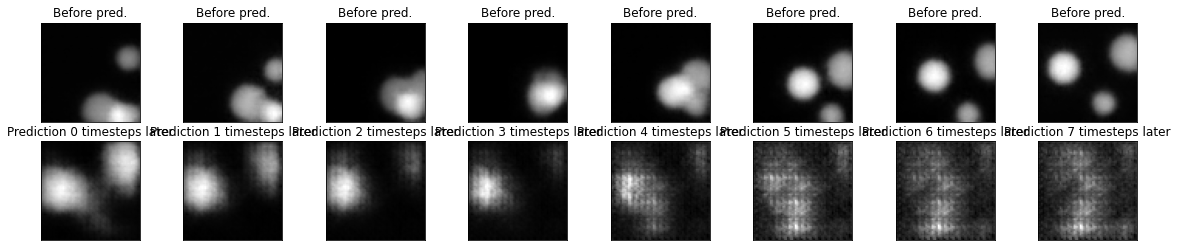

In [65]:
## PREDICT FUTURE WITH LSTM

## Ta in en video med 9 frames

## Predicta den 10ende

## Appenda den 10ende och poppa första

## Fortsätt typ 10 ggr




goal = np.reshape(val_x[16],(9,128))
# goal = autoencoder.decoder.predict(goal)

transform_test = model.predict(transform_in)
goal = autoencoder.decoder.predict(goal)
transform_test = autoencoder.decoder.predict(transform_test)


transform_in = val_x[16]
transform_in = np.reshape(transform_in,(1,9,latent_dim))


n = 8
plt.figure(figsize=(20, 4))
for i in range(n):

  ax = plt.subplot(2, n, i + 1)
  plt.imshow(goal[i].squeeze(), cmap="gray")
  plt.title("Before pred.")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)

  transform_test = lstm_model.predict(transform_in)

  transform_in = np.reshape(transform_in,(9,latent_dim))
  transform_in = np.vstack((transform_in,transform_test))
  transform_in = transform_in[1:10,:]

  transform_in = np.reshape(transform_in,(1,9,latent_dim))


  transform_test = autoencoder.decoder.predict(transform_test)
  plt.imshow(transform_test.squeeze(), cmap="gray")
  plt.title(f"Prediction {i} timesteps later")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()